In [2]:
import os
import gzip
import pickle
import numpy as np
import torch
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from tqdm import tqdm
from ebm.model import Network
import networkx as nx
from ebm.external_world import ExternalWorld, MNISTExternalWorld

from ebm.train_model import *


def pi(s):
    return torch.clamp(s, 0.0, 1.0)

class ExternalWorld:
    def __init__(self, x_values, y_values):
        self.x = torch.tensor(x_values, dtype=torch.float32)
        self.y = torch.tensor(y_values, dtype=torch.int64)
        self.size_dataset = len(self.x)



In [9]:
def train_net(net: Network, plot_graph = False):
    history = {"Energy": [], "Cost": [], "Error": []}
    epochs, batch_size = net.hyperparameters["n_epochs"], net.hyperparameters["batch_size"]
    n_batches = net.dataset_size // batch_size
    n_it_neg, n_it_pos, alphas = net.hyperparameters["n_it_neg"], net.hyperparameters["n_it_pos"], net.hyperparameters["alphas"]


    snapshot_epochs = np.linspace(0, epochs - 1, 5, dtype=int)
    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as epoch_bar:
        for epoch in range(epochs):
            for i in range(n_batches):
                net.update_mini_batch_index(i)
                net.negative_phase(n_it_neg)
                net.positive_phase(n_it_pos, *alphas)

                for i in range(0,len(net.biases)):
                    net.biases[i]*= 0 
                net.weights[-1] = torch.tensor([[-1.,1.]]) 
                
                # = [
                #     torch.tensor([[-1.,  1.],
                #                 [ 1., -1.]]),           # Input → Hidden
                #     torch.tensor([[1.],
                #                 [1.]]),            # Hidden → Output
                #     torch.tensor([[-1.,1.]])    # Final classifier layer (if used)
                # ]


            # Measure and log
            E, C, error = net.measure()
            history["Energy"].append(E)
            history["Cost"].append(C)
            history["Error"].append(error * 100)

            # Update progress bar description instead of using set_postfix()
            epoch_bar.set_description(f"Epoch {epoch+1}/{epochs} | E={E:.2f} C={C:.5f} Error={error*100:.2f}%")
            epoch_bar.update(1)
            if(plot_graph):
                if epoch in snapshot_epochs:
                    plot_network_weights(net, epoch)

    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    for ax, (key, color) in zip(axes, [("Energy", "blue"), ("Cost", "orange"), ("Error", "red")]):
        ax.plot(history[key], label=key, color=color)
        ax.set_title(f"{key} over Epochs")
    plt.tight_layout()
    plt.show()

In [10]:
import torch.nn as nn
# XOR dataset
xor_x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]] * 10, dtype=np.float32)
xor_y = np.array([0, 1, 1, 0] * 10, dtype=np.int64)

# ExternalWorld instance with XOR data
xor_world = ExternalWorld(xor_x, xor_y)



# # small nets can solve xor
# xor_net = Network(
#     name="xor_net",
#     external_world=xor_world,
#     hyperparameters={
#         "hidden_sizes": [2, 1],
#         "output_size": 2,
#         "batch_size": 4,
#         "n_epochs": 100,
#         "n_it_neg": 1,
#         "n_it_pos": 1,
#         "alphas": [np.float32(0.1), np.float32(0.1),  np.float32(0.05)]
#     }
# )


tensor([-1., -1., -1., -1.])


Epoch 1/2 | E=0.25 C=0.50000 Error=50.00%:   0%|          | 0/2 [00:00<?, ?epoch/s]

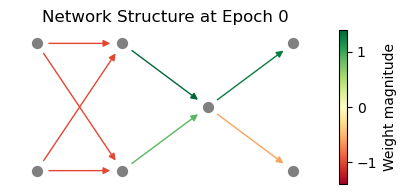

Epoch 2/2 | E=0.25 C=0.50000 Error=50.00%:  50%|█████     | 1/2 [00:00<00:00, 13.55epoch/s]

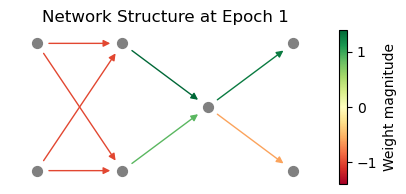

Epoch 2/2 | E=0.25 C=0.50000 Error=50.00%: 100%|██████████| 2/2 [00:00<00:00, 16.83epoch/s]


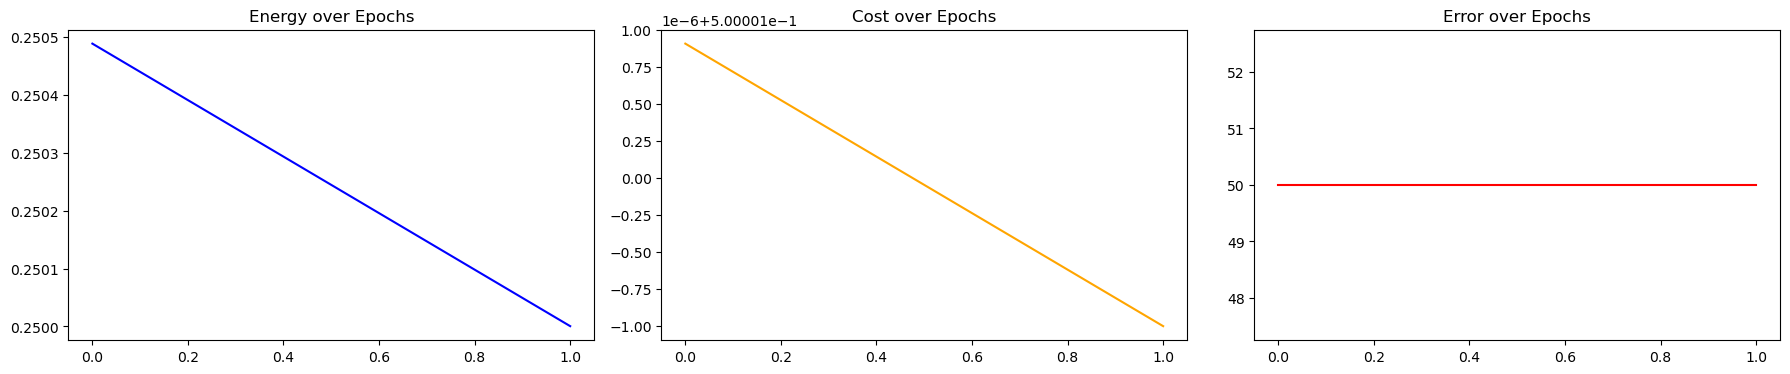

[tensor([0., 0.]), tensor([0., 0.]), tensor([0.]), tensor([0.5000, 0.5000])]
[tensor([[-1., -1.],
        [-1., -1.]]), tensor([[0.8785],
        [1.3911]]), tensor([[-0.6079,  1.2742]])]
tensor([-1., -1., -1.,  1.])


Epoch 1/2 | E=0.11 C=0.32042 Error=25.00%:   0%|          | 0/2 [00:00<?, ?epoch/s]

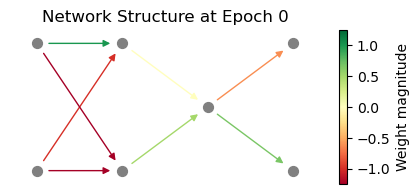

Epoch 2/2 | E=0.11 C=0.33411 Error=25.00%:  50%|█████     | 1/2 [00:00<00:00, 18.16epoch/s]

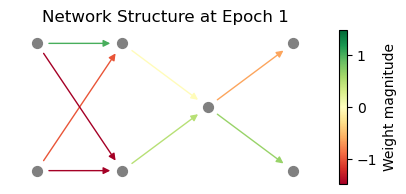

Epoch 2/2 | E=0.11 C=0.33411 Error=25.00%: 100%|██████████| 2/2 [00:00<00:00, 19.80epoch/s]


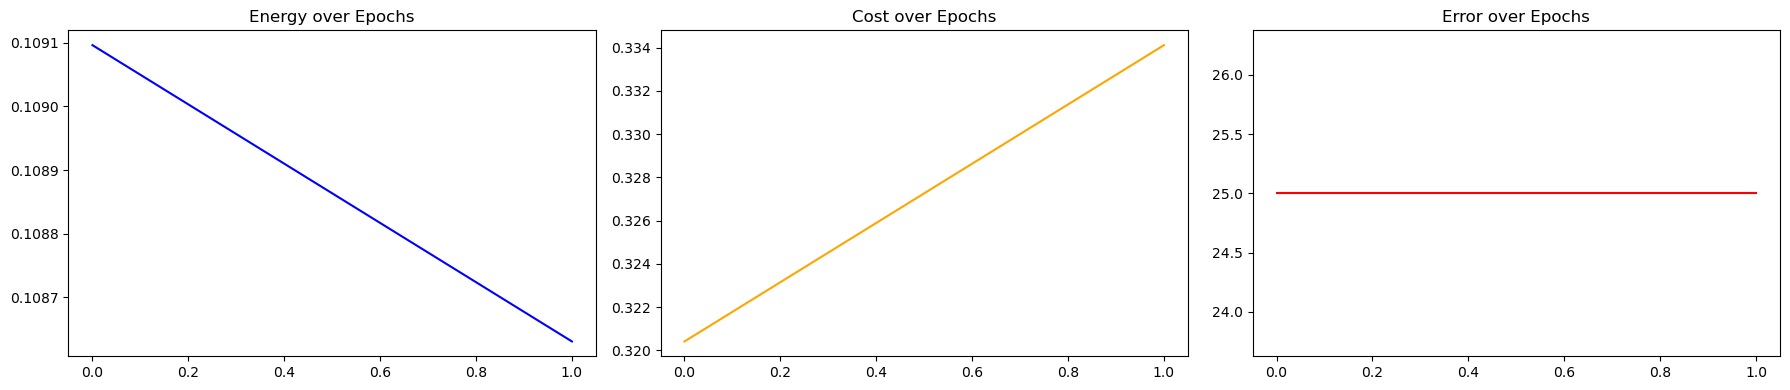

[tensor([0., 0.]), tensor([1.7881e-08, 7.4506e-09]), tensor([-7.4506e-09]), tensor([0.5000, 0.5000])]
[tensor([[-1.4744, -1.0000],
        [-1.4744,  1.0000]]), tensor([[ 0.4947],
        [-0.0321]]), tensor([[ 0.6473, -0.6225]])]
tensor([-1., -1.,  1., -1.])


Epoch 1/2 | E=0.07 C=0.34320 Error=25.00%:   0%|          | 0/2 [00:00<?, ?epoch/s]

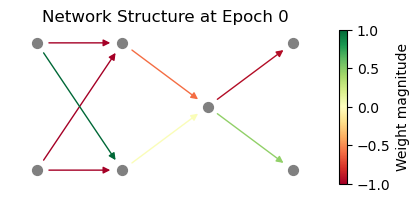

Epoch 2/2 | E=0.16 C=0.95464 Error=75.00%:  50%|█████     | 1/2 [00:00<00:00, 18.42epoch/s]

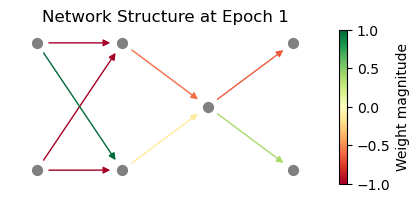

Epoch 2/2 | E=0.16 C=0.95464 Error=75.00%: 100%|██████████| 2/2 [00:00<00:00, 20.01epoch/s]


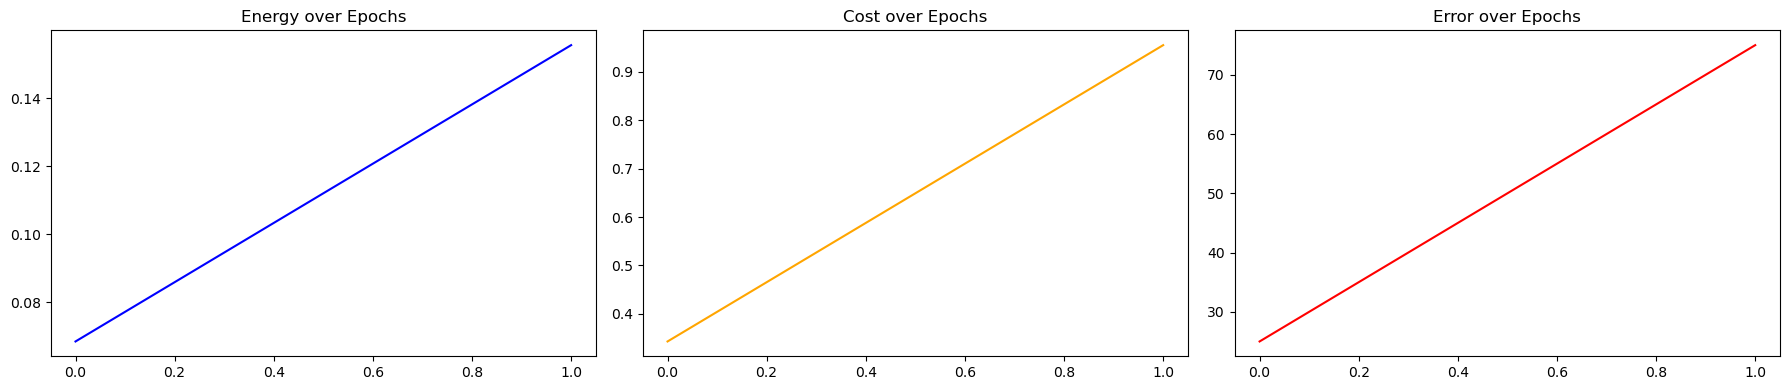

[tensor([0., 0.]), tensor([-1.4901e-08,  0.0000e+00]), tensor([1.8626e-08]), tensor([0.5000, 0.5063])]
[tensor([[-1.0000, -1.0000],
        [ 1.0000, -1.0000]]), tensor([[-0.1309],
        [-0.5991]]), tensor([[ 0.3901, -0.6634]])]
tensor([-1., -1.,  1.,  1.])


Epoch 1/2 | E=-0.06 C=0.34124 Error=25.00%:   0%|          | 0/2 [00:00<?, ?epoch/s]

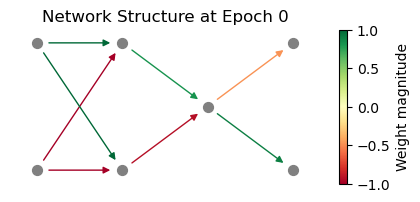

Epoch 2/2 | E=0.03 C=0.96635 Error=75.00%:  50%|█████     | 1/2 [00:00<00:00, 19.35epoch/s]

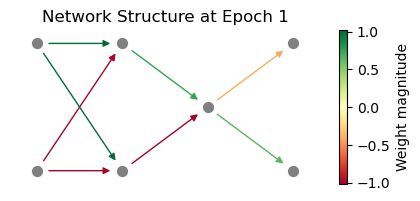

Epoch 2/2 | E=0.03 C=0.96635 Error=75.00%: 100%|██████████| 2/2 [00:00<00:00, 20.02epoch/s]


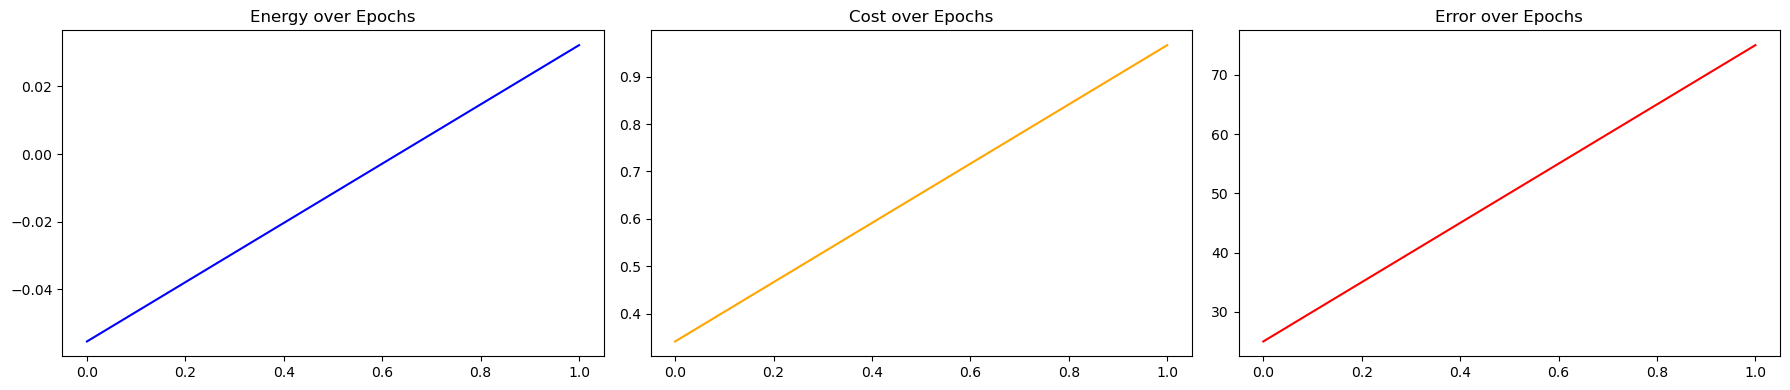

[tensor([0., 0.]), tensor([0.0000e+00, 3.1292e-08]), tensor([-3.3528e-08]), tensor([0.4939, 0.5000])]
[tensor([[-1.0000, -0.9968],
        [ 1.0000,  0.9967]]), tensor([[-1.0206],
        [ 0.7477]]), tensor([[ 0.6511, -0.4203]])]
tensor([-1.,  1., -1., -1.])


Epoch 1/2 | E=0.16 C=0.58989 Error=75.00%:   0%|          | 0/2 [00:00<?, ?epoch/s]

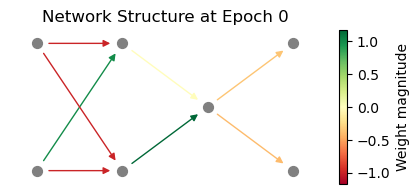

Epoch 2/2 | E=0.20 C=0.52635 Error=75.00%:  50%|█████     | 1/2 [00:00<00:00, 16.42epoch/s]

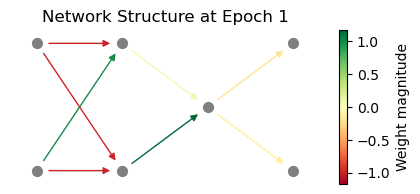

Epoch 2/2 | E=0.20 C=0.52635 Error=75.00%: 100%|██████████| 2/2 [00:00<00:00,  8.15epoch/s]


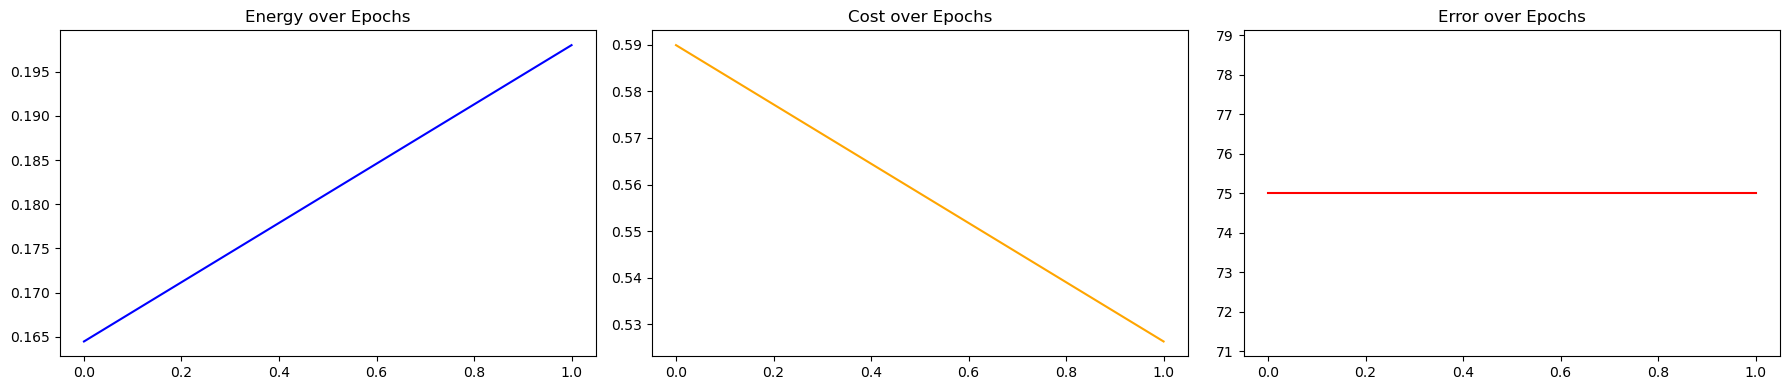

[tensor([0., 0.]), tensor([0., 0.]), tensor([2.7940e-08]), tensor([0.5000, 0.5000])]
[tensor([[-1.,  1.],
        [-1., -1.]]), tensor([[1.1752],
        [0.0817]]), tensor([[-0.1235, -0.1952]])]
tensor([-1.,  1., -1.,  1.])


Epoch 1/2 | E=-0.04 C=0.34144 Error=25.00%:   0%|          | 0/2 [00:00<?, ?epoch/s]

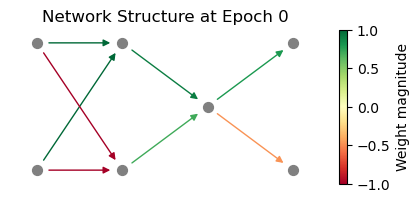

Epoch 2/2 | E=0.00 C=0.33446 Error=25.00%:  50%|█████     | 1/2 [00:00<00:00, 16.98epoch/s]

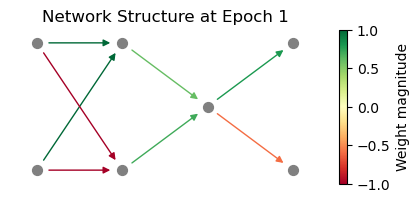

Epoch 2/2 | E=0.00 C=0.33446 Error=25.00%: 100%|██████████| 2/2 [00:00<00:00, 18.71epoch/s]


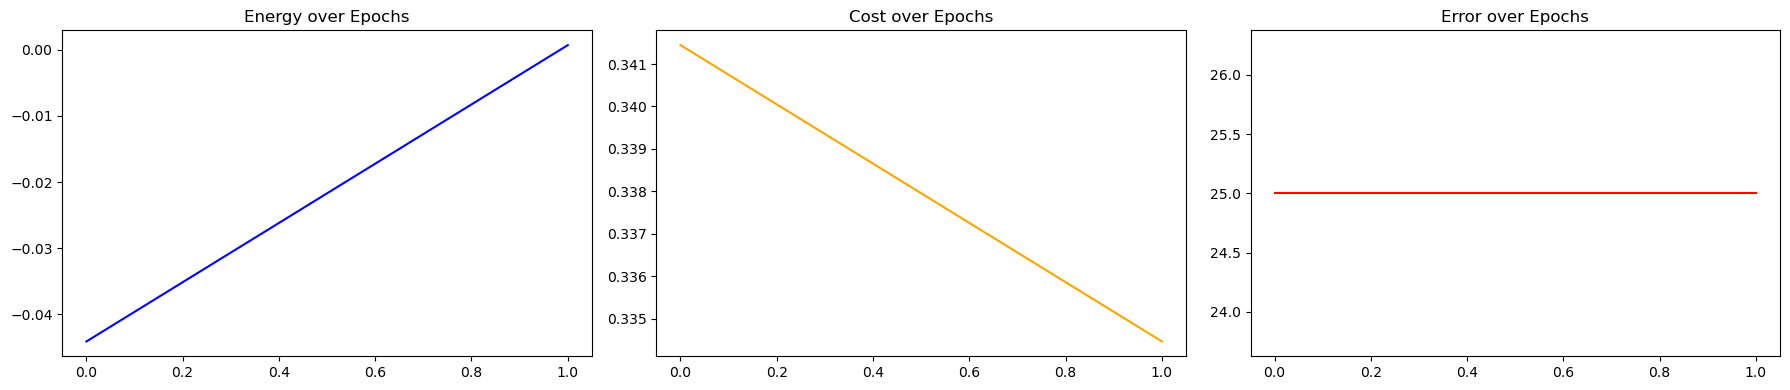

[tensor([0., 0.]), tensor([0., 0.]), tensor([-8.1956e-08]), tensor([0.5000, 0.4691])]
[tensor([[-1.,  1.],
        [-1.,  1.]]), tensor([[0.6986],
        [0.5962]]), tensor([[-0.5963,  0.7901]])]
tensor([-1.,  1.,  1., -1.])


Epoch 1/2 | E=-0.16 C=0.03320 Error=0.00%:   0%|          | 0/2 [00:00<?, ?epoch/s]

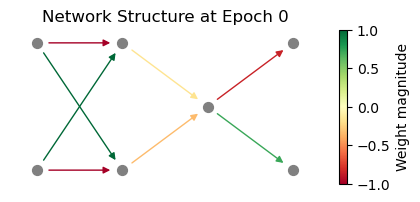

Epoch 2/2 | E=-0.23 C=0.00230 Error=0.00%:  50%|█████     | 1/2 [00:00<00:00, 18.81epoch/s]

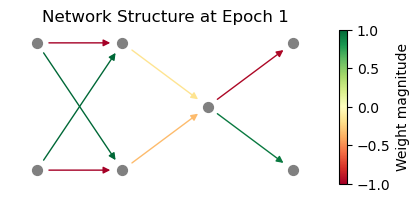

Epoch 2/2 | E=-0.23 C=0.00230 Error=0.00%: 100%|██████████| 2/2 [00:00<00:00, 17.26epoch/s]


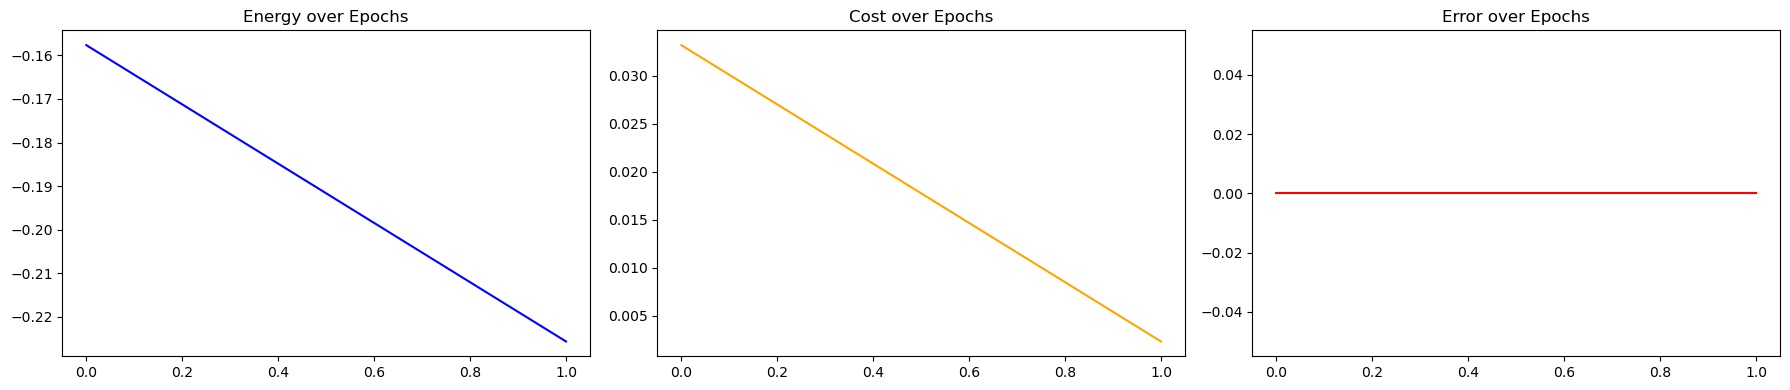

[tensor([0., 0.]), tensor([0., 0.]), tensor([0.]), tensor([0.5000, 0.5000])]
[tensor([[-1.,  1.],
        [ 1., -1.]]), tensor([[-0.3451],
        [-0.1786]]), tensor([[ 0.9253, -0.9621]])]
tensor([-1.,  1.,  1.,  1.])


Epoch 1/2 | E=-0.06 C=0.35025 Error=25.00%:   0%|          | 0/2 [00:00<?, ?epoch/s]

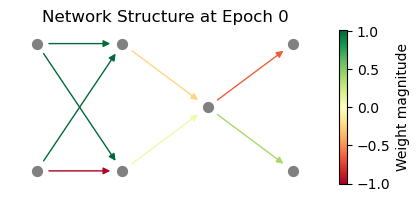

Epoch 2/2 | E=-0.07 C=0.30652 Error=25.00%:  50%|█████     | 1/2 [00:00<00:00, 17.73epoch/s]

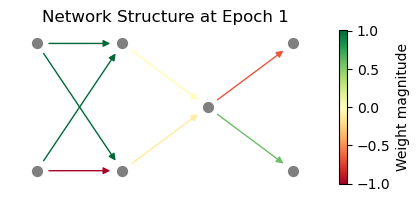

Epoch 2/2 | E=-0.07 C=0.30652 Error=25.00%: 100%|██████████| 2/2 [00:00<00:00, 19.22epoch/s]


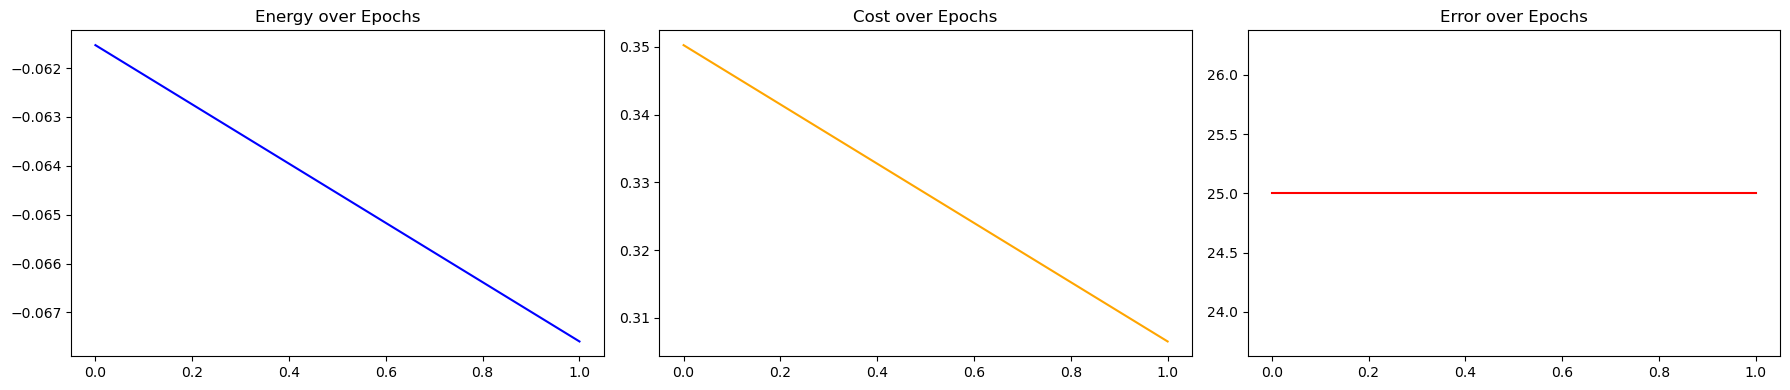

[tensor([0., 0.]), tensor([-1.4156e-08, -5.9605e-09]), tensor([6.7055e-08]), tensor([0.5000, 0.5000])]
[tensor([[-0.9892,  1.0000],
        [ 1.0075,  1.0000]]), tensor([[-0.1259],
        [-0.0307]]), tensor([[ 0.5835, -0.6817]])]
tensor([ 1., -1., -1., -1.])


Epoch 1/2 | E=0.06 C=0.33451 Error=25.00%:   0%|          | 0/2 [00:00<?, ?epoch/s]

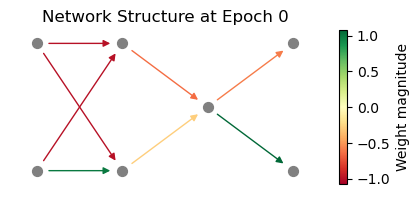

Epoch 2/2 | E=0.11 C=0.33353 Error=25.00%:  50%|█████     | 1/2 [00:00<00:00, 16.24epoch/s]

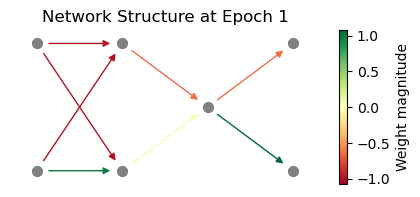

Epoch 2/2 | E=0.11 C=0.33353 Error=25.00%: 100%|██████████| 2/2 [00:00<00:00, 17.87epoch/s]


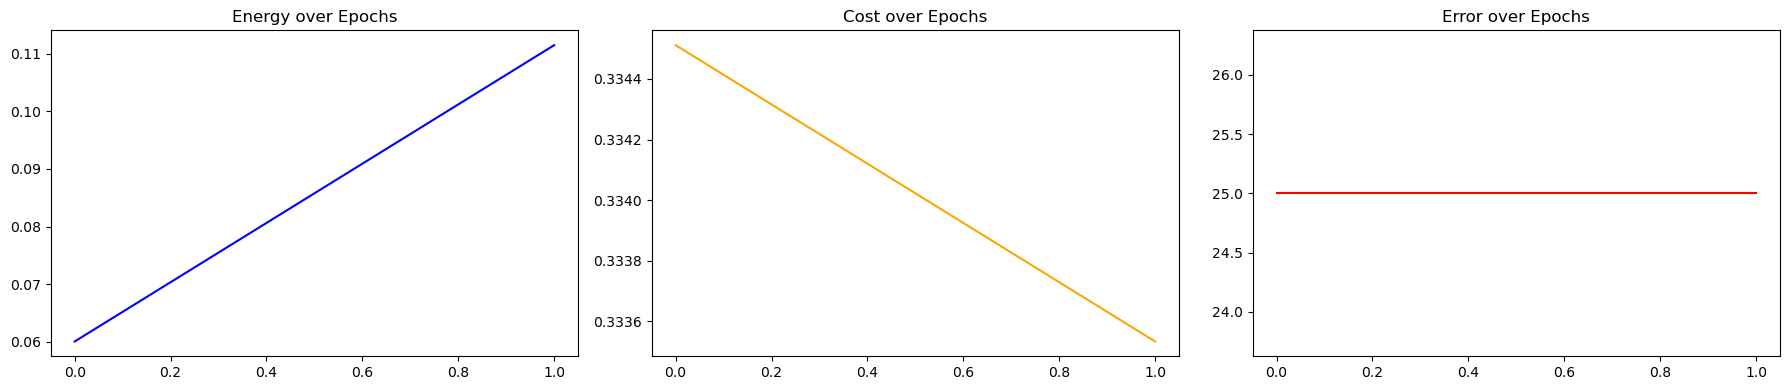

[tensor([0., 0.]), tensor([0., 0.]), tensor([2.2352e-08]), tensor([0.3978, 0.5000])]
[tensor([[ 1., -1.],
        [-1., -1.]]), tensor([[ 0.0231],
        [-0.6433]]), tensor([[ 1.0780, -0.6404]])]
tensor([ 1., -1., -1.,  1.])


Epoch 1/2 | E=-0.12 C=0.58705 Error=25.00%:   0%|          | 0/2 [00:00<?, ?epoch/s]

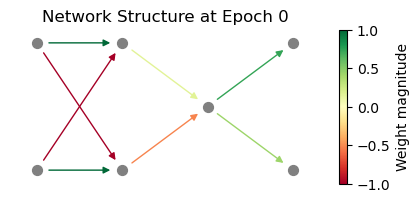

Epoch 2/2 | E=-0.09 C=0.48518 Error=25.00%:  50%|█████     | 1/2 [00:00<00:00, 13.45epoch/s]

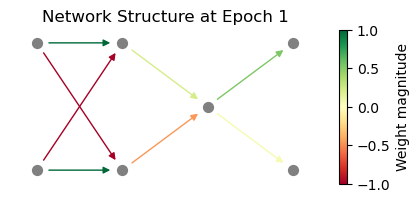

Epoch 2/2 | E=-0.09 C=0.48518 Error=25.00%: 100%|██████████| 2/2 [00:00<00:00, 16.40epoch/s]


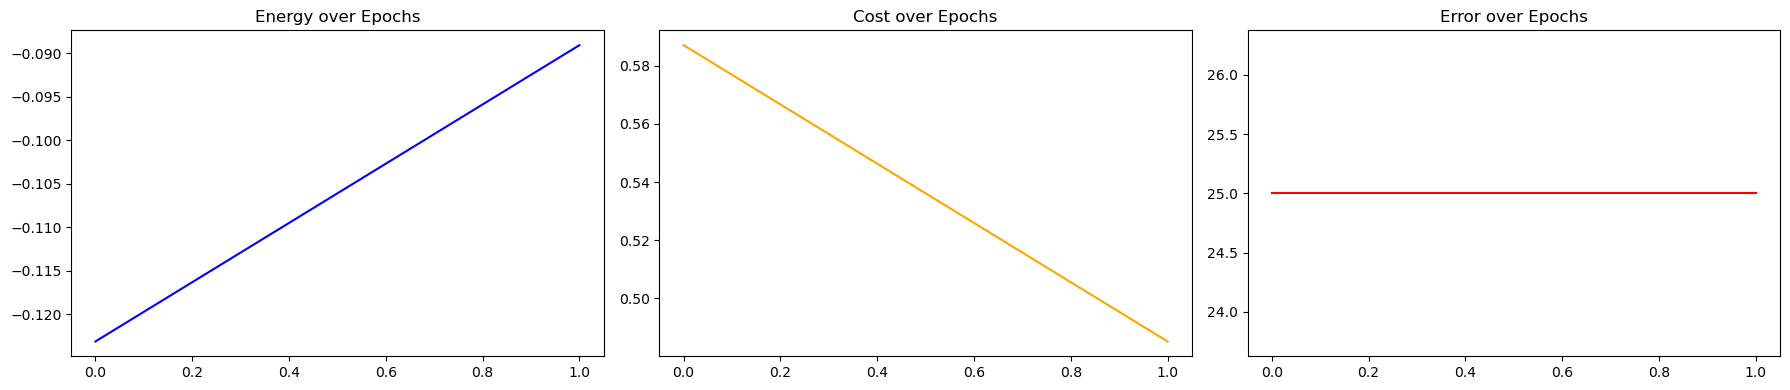

[tensor([0., 0.]), tensor([ 2.9802e-09, -1.4901e-09]), tensor([3.3528e-08]), tensor([0.5000, 0.5000])]
[tensor([[ 1., -1.],
        [-1.,  1.]]), tensor([[-0.4627],
        [ 0.2181]]), tensor([[0.0522, 0.5274]])]
tensor([ 1., -1.,  1., -1.])


Epoch 1/2 | E=0.06 C=0.35476 Error=25.00%:   0%|          | 0/2 [00:00<?, ?epoch/s]

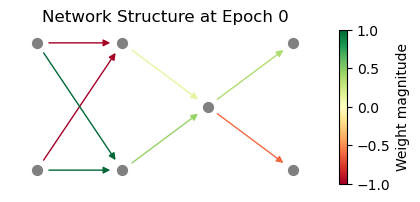

Epoch 2/2 | E=0.09 C=0.33633 Error=25.00%:  50%|█████     | 1/2 [00:00<00:00, 18.32epoch/s]

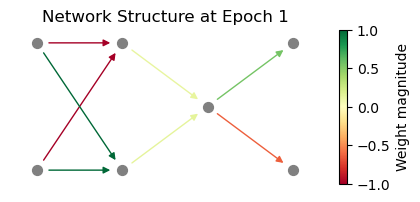

Epoch 2/2 | E=0.09 C=0.33633 Error=25.00%: 100%|██████████| 2/2 [00:00<00:00, 19.37epoch/s]


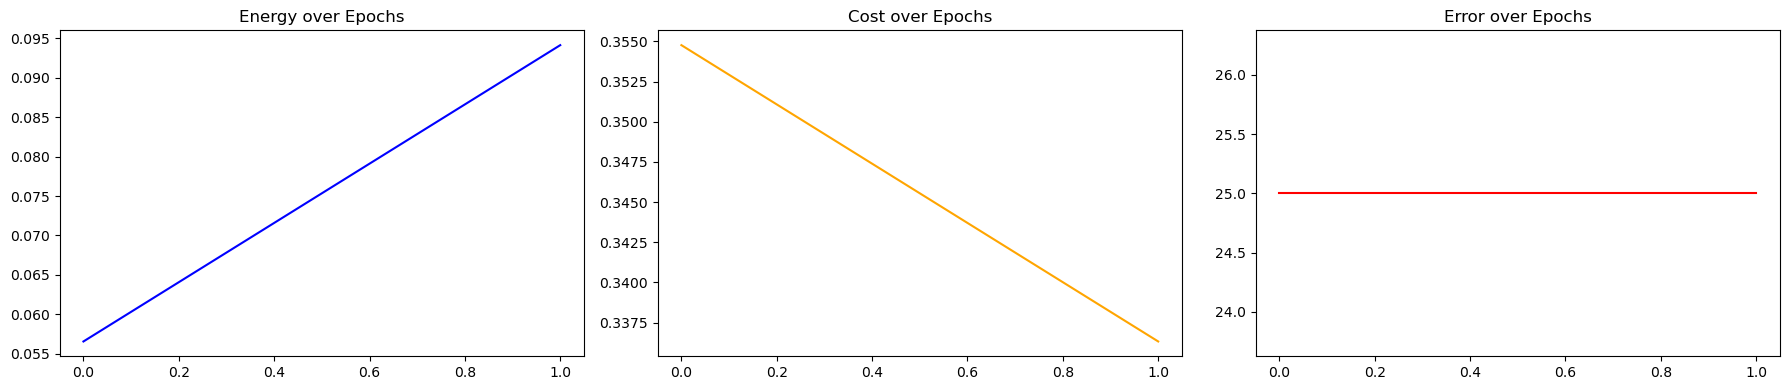

[tensor([0., 0.]), tensor([0., 0.]), tensor([7.4506e-09]), tensor([0.5000, 0.5000])]
[tensor([[ 1., -1.],
        [ 1., -1.]]), tensor([[0.1357],
        [0.1186]]), tensor([[-0.6462,  0.5541]])]
tensor([ 1., -1.,  1.,  1.])


Epoch 1/2 | E=-0.14 C=0.26319 Error=25.00%:   0%|          | 0/2 [00:00<?, ?epoch/s]

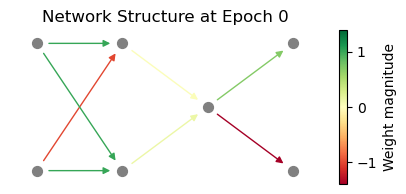

Epoch 2/2 | E=-0.16 C=0.25457 Error=25.00%:  50%|█████     | 1/2 [00:00<00:00, 18.62epoch/s]

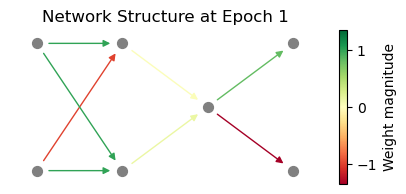

Epoch 2/2 | E=-0.16 C=0.25457 Error=25.00%: 100%|██████████| 2/2 [00:00<00:00, 20.45epoch/s]


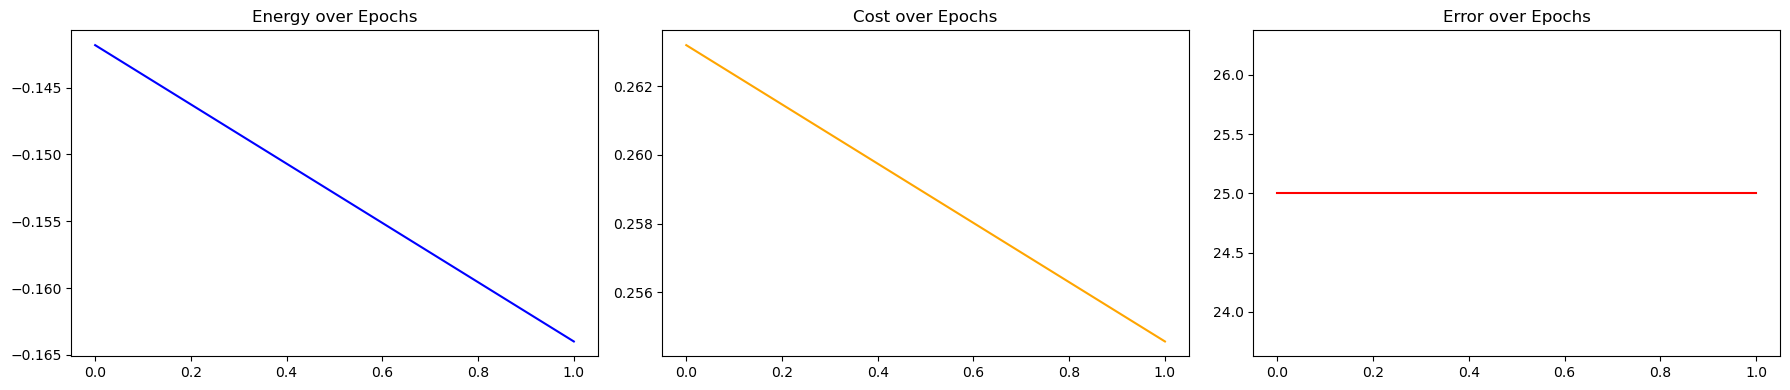

[tensor([0., 0.]), tensor([ 2.2204e-16, -4.4703e-09]), tensor([4.4703e-08]), tensor([0.4890, 0.5000])]
[tensor([[ 1.0000, -1.0000],
        [ 1.0000,  1.0000]]), tensor([[0.1407],
        [0.0297]]), tensor([[-1.3501,  0.8218]])]
tensor([ 1.,  1., -1., -1.])


Epoch 1/2 | E=-0.34 C=0.33341 Error=25.00%:   0%|          | 0/2 [00:00<?, ?epoch/s]

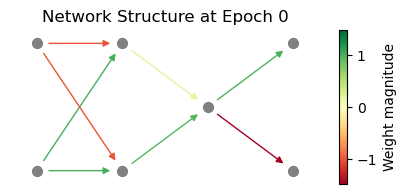

Epoch 2/2 | E=-0.26 C=0.33333 Error=25.00%:  50%|█████     | 1/2 [00:00<00:00, 15.07epoch/s]

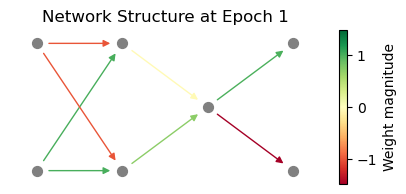

Epoch 2/2 | E=-0.26 C=0.33333 Error=25.00%: 100%|██████████| 2/2 [00:00<00:00, 17.84epoch/s]


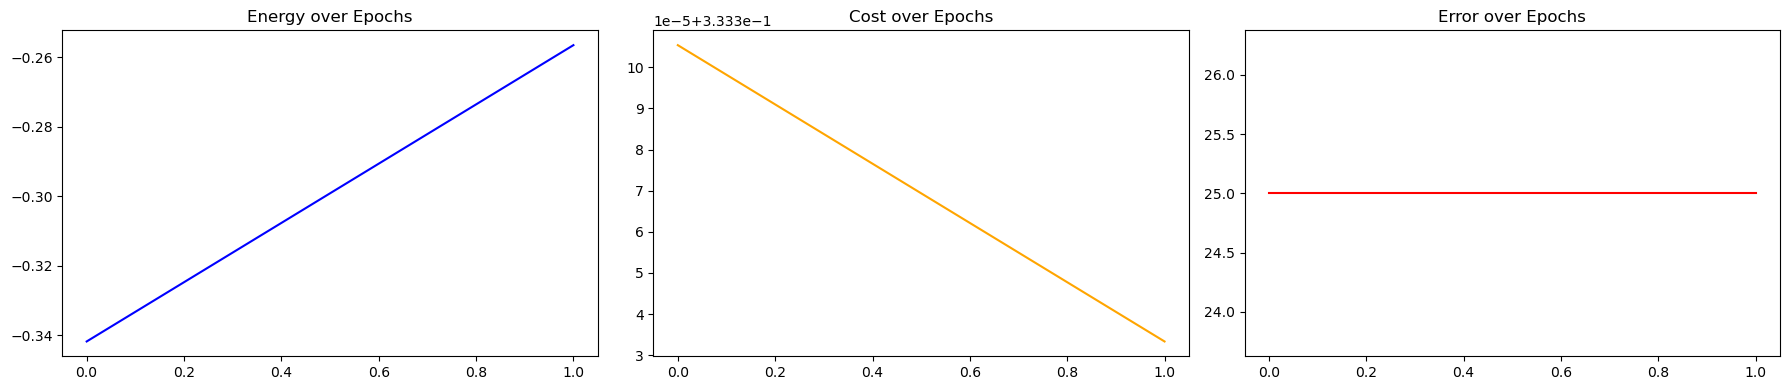

[tensor([0., 0.]), tensor([ 0.0000e+00, -1.4901e-09]), tensor([1.8626e-09]), tensor([0.2978, 0.5804])]
[tensor([[ 1.,  1.],
        [-1., -1.]]), tensor([[ 0.7080],
        [-0.0470]]), tensor([[-1.4755,  0.9886]])]
tensor([ 1.,  1., -1.,  1.])


Epoch 1/2 | E=-0.16 C=0.39917 Error=25.00%:   0%|          | 0/2 [00:00<?, ?epoch/s]

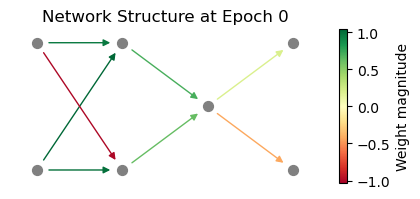

Epoch 2/2 | E=-0.18 C=0.34307 Error=25.00%:  50%|█████     | 1/2 [00:00<00:00, 18.11epoch/s]

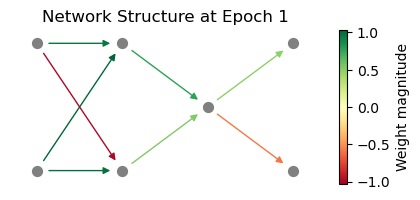

Epoch 2/2 | E=-0.18 C=0.34307 Error=25.00%: 100%|██████████| 2/2 [00:00<00:00, 16.71epoch/s]


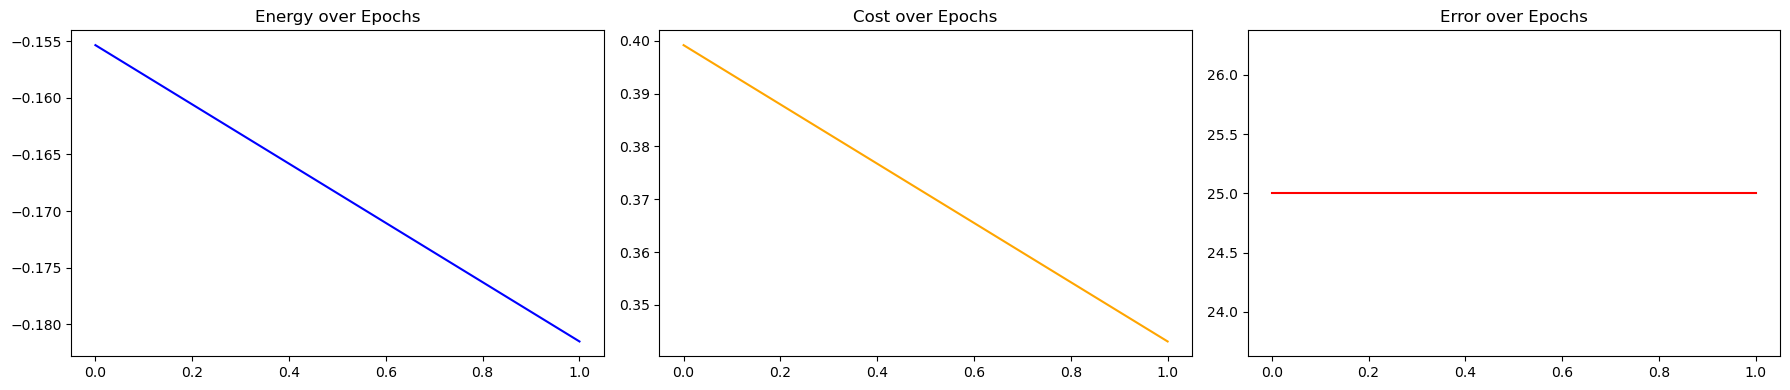

[tensor([0., 0.]), tensor([ 0.0000e+00, -2.9802e-08]), tensor([2.9802e-08]), tensor([0.5000, 0.5000])]
[tensor([[ 1.0000,  1.0329],
        [-1.0000,  0.9671]]), tensor([[0.5316],
        [0.7731]]), tensor([[-0.5851,  0.4917]])]
tensor([ 1.,  1.,  1., -1.])


Epoch 1/2 | E=-0.09 C=0.33539 Error=25.00%:   0%|          | 0/2 [00:00<?, ?epoch/s]

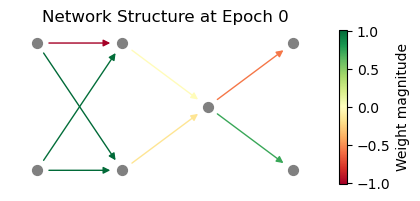

Epoch 2/2 | E=-0.10 C=0.26661 Error=25.00%: 100%|██████████| 2/2 [00:00<00:00, 10.83epoch/s]

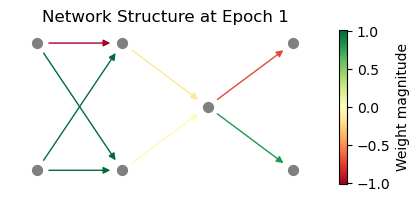

Epoch 2/2 | E=-0.10 C=0.26661 Error=25.00%: 100%|██████████| 2/2 [00:00<00:00,  8.01epoch/s]


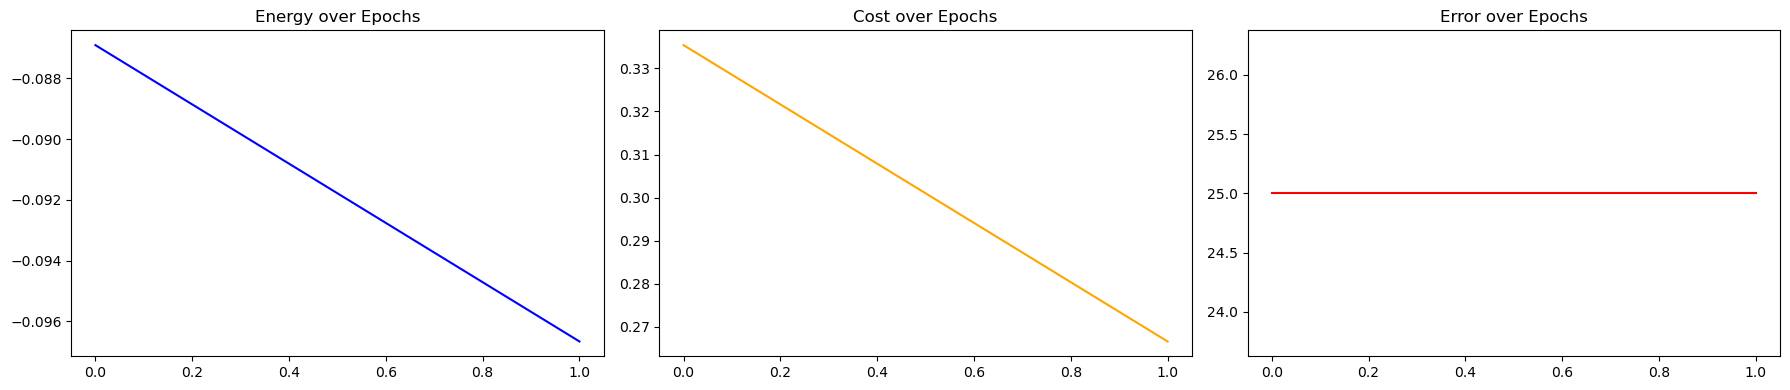

[tensor([0., 0.]), tensor([0.0000e+00, 1.4901e-09]), tensor([-3.7253e-09]), tensor([0.5002, 0.5000])]
[tensor([[ 1.0000,  0.9846],
        [ 1.0000, -1.0154]]), tensor([[-0.0338],
        [-0.1582]]), tensor([[ 0.8031, -0.7228]])]
tensor([1., 1., 1., 1.])


Epoch 1/2 | E=-0.06 C=0.34295 Error=25.00%:   0%|          | 0/2 [00:00<?, ?epoch/s]

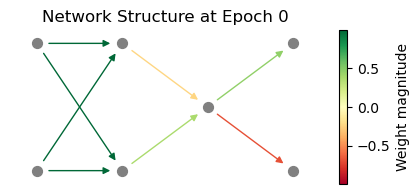

Epoch 2/2 | E=0.05 C=0.90041 Error=75.00%:  50%|█████     | 1/2 [00:00<00:00, 17.72epoch/s]

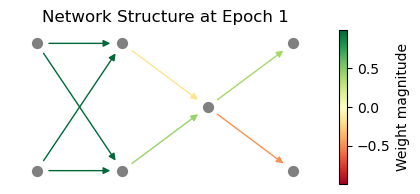

Epoch 2/2 | E=0.05 C=0.90041 Error=75.00%: 100%|██████████| 2/2 [00:00<00:00, 16.36epoch/s]


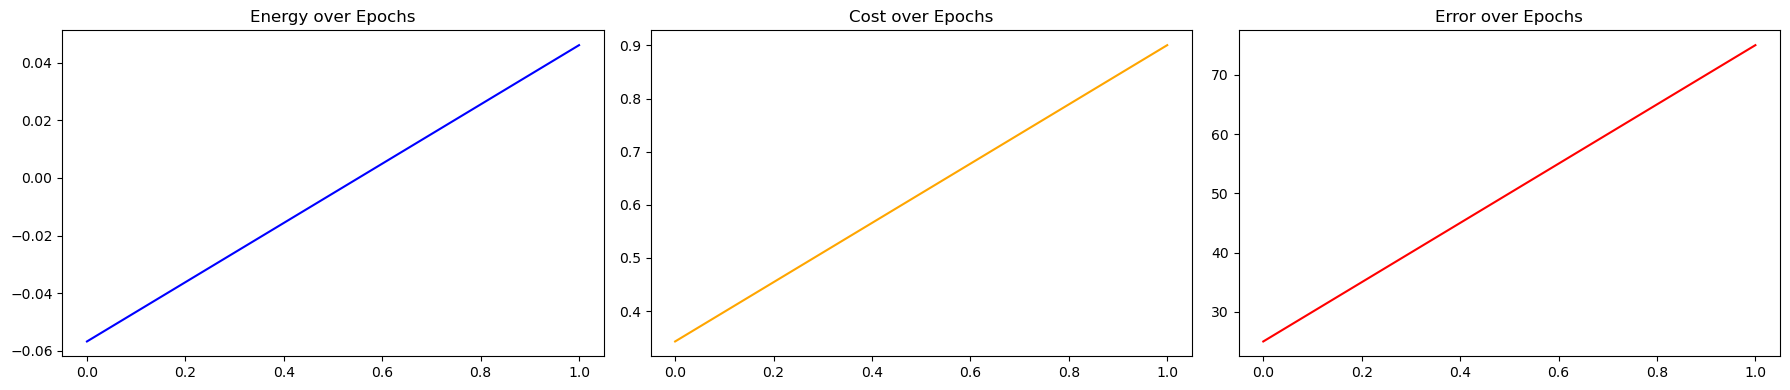

[tensor([0., 0.]), tensor([ 2.9802e-08, -4.4703e-09]), tensor([4.2841e-08]), tensor([0.5000, 0.5000])]
[tensor([[1.0000, 1.0000],
        [1.0000, 1.0000]]), tensor([[ 0.4450],
        [-0.1766]]), tensor([[-0.4916,  0.4025]])]


In [ ]:
import itertools
import numpy as np
import torch

# Generate all possible combinations of -1, 0, 1 for 9 parameters
all_inits = list(itertools.product([-1.0, 1.0], repeat=6))

results = []

for i, init in enumerate(all_inits):
    xor_net = Network(
        name=f"xor_trial_{i}",
        external_world=xor_world,
        hyperparameters={
            "hidden_sizes": [2, 1],
            "output_size": 2,
            "batch_size": 4,
            "n_epochs": 2,  # just test untrained net
            "n_it_neg": 1,
            "n_it_pos": 1,
            "alphas": [0.2, 0.5, 0.5]
        }
    )

    # Unpack init into weights and biases
    init = torch.tensor(init, dtype=torch.float32)
    W0 = init[:4].reshape(2, 2)
    # b1 = init[4:6]
    W1 = init[6:8].reshape(2, 1)
    # b2 = init[8:]

    with torch.no_grad():
        xor_net.weights[0][:] = W0
        # xor_net.biases[1][:] = b1
        xor_net.weights[1][:] = W1
        # xor_net.biases[2][:] = b2

    print(init)

    # Evaluate the net — assume this function exists
    train_net(xor_net, plot_graph= True)

    print(xor_net.biases)
    print(xor_net.weights)

    # results.append((i, acc.item(), init.numpy()))


Epoch 1/100 | E=0.34 C=0.56262 Error=25.00%:   0%|          | 0/100 [00:00<?, ?epoch/s]

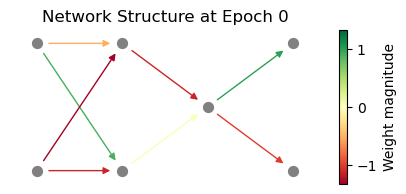

Epoch 25/100 | E=0.34 C=0.56262 Error=25.00%:  24%|██▍       | 24/100 [00:00<00:00, 78.22epoch/s]

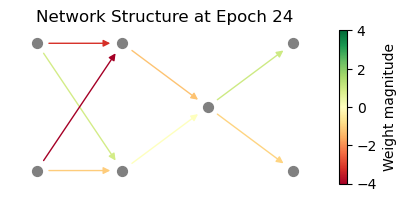

Epoch 50/100 | E=0.35 C=1.05613 Error=75.00%:  49%|████▉     | 49/100 [00:00<00:00, 125.94epoch/s]

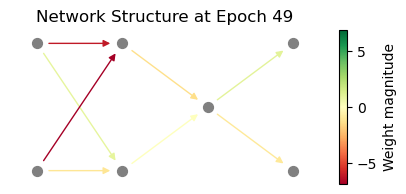

Epoch 75/100 | E=0.34 C=0.56289 Error=25.00%:  74%|███████▍  | 74/100 [00:00<00:00, 170.92epoch/s]

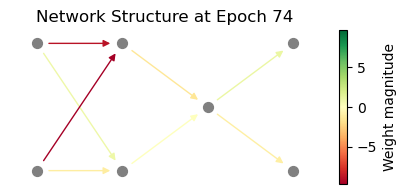

Epoch 100/100 | E=0.34 C=0.56286 Error=25.00%:  99%|█████████▉| 99/100 [00:00<00:00, 138.56epoch/s]

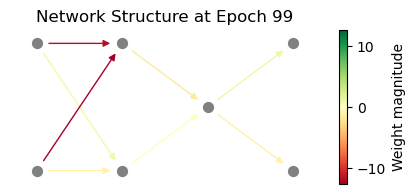

Epoch 100/100 | E=0.34 C=0.56286 Error=25.00%: 100%|██████████| 100/100 [00:00<00:00, 136.55epoch/s]


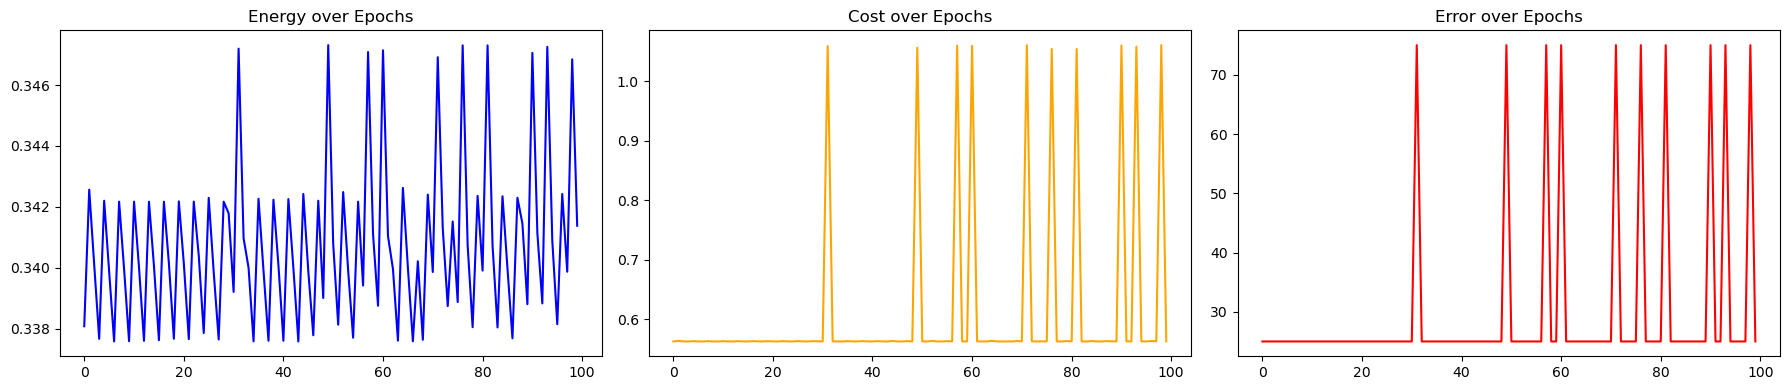

[tensor([0., 0.]), tensor([0., -0.]), tensor([-0.]), tensor([0., 0.])]
[tensor([[  0.8912, -11.7871],
        [ -1.1231, -12.5841]]), tensor([[ 0.0031],
        [-1.5882]]), tensor([[-1.,  1.]])]


In [11]:
import torch.nn as nn
# XOR dataset
xor_x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]] * 10, dtype=np.float32)
xor_y = np.array([0, 1, 1, 0] * 10, dtype=np.int64)

# ExternalWorld instance with XOR data
xor_world = ExternalWorld(xor_x, xor_y)



# small nets can solve xor
xor_net = Network(
    name="xor_net",
    external_world=xor_world,
    hyperparameters={
        "hidden_sizes": [2, 1],
        "output_size": 2,
        "batch_size": 4,
        "n_epochs": 100,
        "n_it_neg": 1,
        "n_it_pos": 1,
        "alphas": [np.float32(0.1), np.float32(0.1),  np.float32(0.05)],
        "activation": "relu"
    }
)

# with torch.no_grad():
#     xor_net.biases = [
#         torch.tensor([0., 0.]),               # Input layer bias (unused)
#         torch.tensor([0., 0.]),               # Hidden layer bias
#         torch.tensor([0.]),                    # Output layer bias
#         torch.tensor([0.0, 0.0])                #classificaiton layer biase
#     ]
    
#     xor_net.weights = [
#         torch.tensor([[-1.,  1.],
#                       [ 1., -1.]]),           # Input → Hidden
#         torch.tensor([[1.],
#                       [1.]]),            # Hidden → Output
#         torch.tensor([[-1.,1.]])    # Final classifier layer (if used)
#     ]



train_net(xor_net, plot_graph= True)

print(xor_net.biases)
print(xor_net.weights)





In [40]:
def train_and_record(net: Network):
    history = {"Energy": [], "Cost": [], "Error": [], "W0_traj": []}
    epochs, batch_size = net.hyperparameters["n_epochs"], net.hyperparameters["batch_size"]
    n_batches = net.dataset_size // batch_size
    n_it_neg, n_it_pos, alphas = net.hyperparameters["n_it_neg"], net.hyperparameters["n_it_pos"], net.hyperparameters["alphas"]

    for epoch in range(epochs):
        for i in range(n_batches):
            net.update_mini_batch_index(i)
            net.negative_phase(n_it_neg)
            net.positive_phase(n_it_pos, *alphas)

        E, C, error = net.measure()
        history["Energy"].append(E)
        history["Cost"].append(C)
        history["Error"].append(error * 100)

        # Save flattened W0 weights for 2D plotting
        w0 = net.weights[0].flatten().detach().cpu().numpy()
        history["W0_traj"].append(w0.copy())

    return history


In [41]:
def compare_initializations(n_trials=10, error_thresh=5.0):
    good_runs, bad_runs = [], []

    for i in range(n_trials):
        net = Network(
            name=f"xor_trial_{i}",
            external_world=xor_world,
            hyperparameters={
                "hidden_sizes": [2, 1],
                "output_size": 2,
                "batch_size": 4,
                "n_epochs": 100,
                "n_it_neg": 1,
                "n_it_pos": 1,
                "alphas": [0.1, 0.1, 0.05]
            }
        )

        # Random init already done in Network constructor
        history = train_and_record(net)

        final_err = history["Error"][-1]
        if final_err < error_thresh:
            good_runs.append(history)
        else:
            bad_runs.append(history)

    return good_runs, bad_runs


In [42]:
def plot_trajectories(runs, title="Trajectory", max_plot=5):
    plt.figure(figsize=(6, 6))
    for i, run in enumerate(runs[:max_plot]):
        traj = np.array(run["W0_traj"])  # shape (epochs, 4)
        plt.plot(traj[:, 0], traj[:, 1], label=f"Run {i}", alpha=0.7)
    plt.title(f"{title} (first 2 dims of W0)")
    plt.xlabel("W0[0]")
    plt.ylabel("W0[1]")
    plt.legend()
    plt.grid(True)
    plt.axis("equal")
    plt.show()


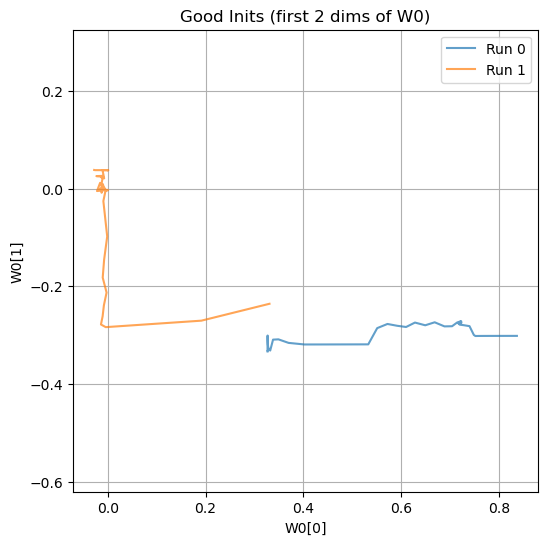

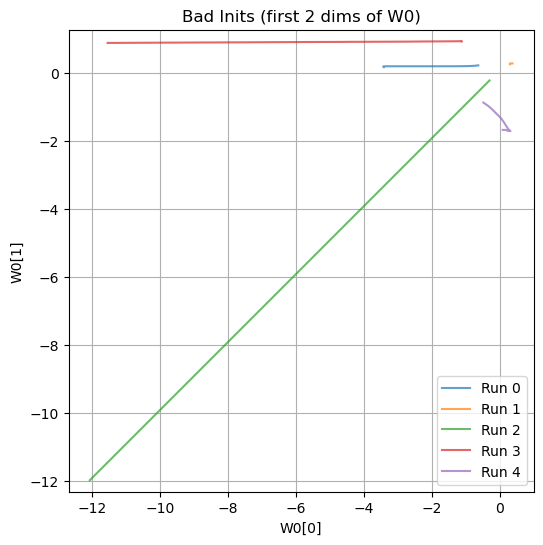

In [43]:
good, bad = compare_initializations(n_trials=20)

plot_trajectories(good, title="Good Inits")
plot_trajectories(bad, title="Bad Inits")
